In [1]:
import os
import json
import numpy as np
import torch as pt
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import bessel, sosfiltfilt

import transport_signal_processing as tsp
from data_manager import DataManager

In [2]:
# parameters
path = "*100mV*"
level = 1
selected_only = True

# setup database connector
sigman = DataManager('database')

# load segments informations
sinfo_l = sigman.load_info(path, 's*')

# convert info to dataframe
df = pd.DataFrame(sinfo_l)

# condition key
exp_keys = ['pore', 'voltage', 'analyte']
df['condition'] = df.apply(lambda x: '-'.join([str(x[k]) for k in exp_keys]), axis=1)

# experience id
exp_keys = ['pore', 'analyte', 'voltage', 'temperature', 'channel', 'replica']
df['uid'] = df.apply(lambda x: '-'.join([str(x[k]) for k in exp_keys]), axis=1)

# manual filter
#df = df[df['analyte'].isin(['4MpS129', '4MWT'])]

# keep only selected segments
df = df[(df['selected'] > (level-1))]
df

,pore,analyte,voltage,temperature,channel,replica,part,sid,segment_range,segment_duration,MODIFIED,mI_open,sI_open,N_events,N_cores,N_reduced,selected,ratio_sel,condition,uid
2,K238A,AYEMPSEE,100,25,002,00,001,0,"[0, 29999999]",299.99999,2022-08-23_09:24:23,70.372226,2.071023,15523,3525.0,3525.0,1.0,0.998582,K238A-100-AYEMPSEE,K238A-AYEMPSEE-100-25-002-00
3,K238A,AYEMPSEE,100,25,002,00,000,0,"[0, 29999999]",299.99999,2022-08-23_09:24:23,69.966650,2.113729,16247,3750.0,3750.0,1.0,0.999200,K238A-100-AYEMPSEE,K238A-AYEMPSEE-100-25-002-00
5,K238A,AYEMPSEE,100,25,000,08,000,0,"[0, 961395]",9.61395,2022-08-23_09:24:23,73.069390,3.080506,31,9.0,9.0,1.0,1.000000,K238A-100-AYEMPSEE,K238A-AYEMPSEE-100-25-000-08
6,K238A,AYEMPSEE,100,25,000,08,000,1,"[1885966, 26702042]",248.16076,2022-08-23_09:24:23,76.156650,2.645054,1586,169.0,169.0,1.0,1.000000,K238A-100-AYEMPSEE,K238A-AYEMPSEE-100-25-000-08
10,K238A,AYEMPSEE,100,25,000,09,000,0,"[0, 46855027]",468.55027,2022-08-23_09:24:23,69.596524,1.846376,6616,516.0,516.0,1.0,0.996124,K238A-100-AYEMPSEE,K238A-AYEMPSEE-100-25-000-09
13,K238A,AYEMPSEE,100,25,000,09,000,1,"[46906279, 152761218]",1058.54939,2022-08-23_09:24:23,70.864074,1.833717,13788,969.0,969.0,1.0,0.993808,K238A-100-AYEMPSEE,K238A-AYEMPSEE-100-25-000-09
17,K238A,AYEMPSEE,100,25,000,09,001,4,"[153603608, 241862945]",882.59337,2022-08-23_09:24:23,73.405696,2.261735,9644,670.0,670.0,1.0,0.988060,K238A-100-AYEMPSEE,K238A-AYEMPSEE-100-25-000-09
18,K238A,AYEMPSEE,100,25,000,09,001,2,"[152826638, 153231234]",4.04596,2022-08-23_09:24:23,72.795549,2.416470,41,4.0,4.0,1.0,1.000000,K238A-100-AYEMPSEE,K238A-AYEMPSEE-100-25-000-09
20,K238A,AYEMPSEE,100,25,000,09,001,0,"[0, 46855027]",468.55027,2022-08-23_09:24:23,70.868409,2.469596,4295,349.0,349.0,1.0,0.985673,K238A-100-AYEMPSEE,K238A-AYEMPSEE-100-25-000-09
23,K238A,AYEMPSEE,100,25,000,09,001,1,"[46906279, 152761218]",1058.54939,2022-08-23_09:24:23,71.789059,2.466163,6471,530.0,530.0,1.0,0.986792,K238A-100-AYEMPSEE,K238A-AYEMPSEE-100-25-000-09


In [3]:
def remove_tails(y, sigma_tol=0.0):
    y_thr = np.mean(y) + sigma_tol * np.std(y)
    i0, i1 = np.where(y < y_thr)[0][[0,-1]]
    return y[i0:i1]

def events_to_features(events, min_output_size=16, sigma_tol=0.0):
    X_l = []
    for evt in events:
        if len(evt) > 1:
            y = evt[:,1]
            #y = remove_tails(y, sigma_tol=sigma_tol)
            if len(y) > min_output_size:
                X_l.append(y)
    return X_l

In [4]:
# paramters
N_min = 100

# find keys
ckey_sels = np.unique(df["condition"].values)

# extract features and labels from events
data = []
for k, ckey in enumerate(ckey_sels):
    # add entry
    data.append({})
    
    # condition subset
    dfs = df[df["condition"] == ckey].copy()
    
    # group by experiment id
    ukey_sels = np.unique(dfs["uid"].values)
    for ukey in tqdm(ukey_sels):
        dfu = dfs[dfs["uid"] == ukey]
        
        # load core events
        events = tsp.utils.load_core_events(sigman, dfu.to_dict('records'), selected_only=selected_only)

        # extract features
        x_l = events_to_features(events)
        y_l = [np.array(k) for x in x_l]
        
        # store data
        if len(x_l) > N_min:    
            # stats fix
            #mx = np.mean([np.mean(x) for x in x_l])
            #sx = np.mean([np.std(x) for x in x_l])
            #x_l = [(x - mx)/sx for x in x_l]
            
            data[-1][ukey] = [x_l, y_l]

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.56it/s]


In [5]:
# split train / test
ukeys_l = []
for i in range(len(data)):
    keys = np.array(list(data[i]))
    n = max(1, int(np.ceil(0.2*len(keys))))
    np.random.shuffle(keys)    
    ukeys_l.append({
        'train': list(keys[n:]),
        'test': list(keys[:n]),
    })

In [6]:
# pack results
X_tr_l, y_tr_l = [], []
X_te_l, y_te_l = [], []
for i in range(len(data)):
    features = data[i]
    ukeys = ukeys_l[i]
    
    for ukey in ukeys['train']:
        X_l, y_l = features[ukey]
        X_tr_l.extend(X_l)
        y_tr_l.extend(y_l)
    
    for ukey in ukeys['test']:
        X_l, y_l = features[ukey]
        X_te_l.extend(X_l)
        y_te_l.extend(y_l)

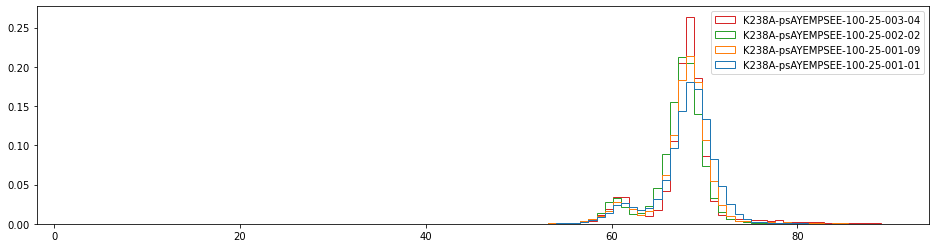

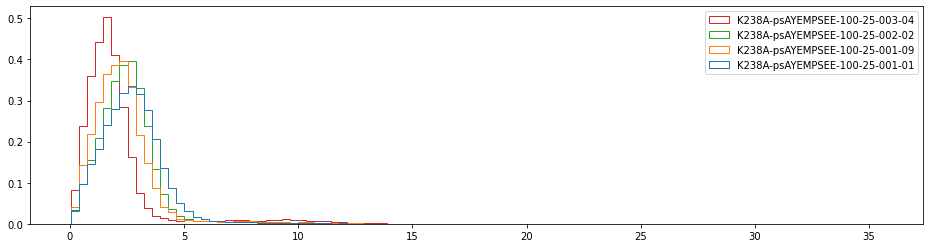

In [11]:
i = 3
mx_l, sx_l = [], []
for key in list(data[i]):
    x_l, _ = data[i][key]
    
    mx = np.array([np.mean(x) for x in x_l])
    sx = np.array([np.std(x) for x in x_l])
    
    mx_l.append(mx)
    sx_l.append(sx)
    
plt.figure(figsize=(16,4))
plt.hist(mx_l, bins=100, histtype='step', density=True, label=list(data[i]))
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(16,4))
plt.hist(sx_l, bins=100, histtype='step', density=True, label=list(data[i]))
plt.legend(loc='best')
plt.show()